## 230523 Starting Metabolomics analysis for spring metabolon experiment
Aim to:
- organize data using the metadata, sort data into vehicle and 2HB, exclude the DEG samples for now
- Conduct differential abundance analysis, enrichment analysis, pathway analysis, hypothesis testing (BCAA metabolism)
- Plot data for final output

In [555]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

### Data organization
- Data is in two separate files, one for serum and one for muscle. This is because the serum had a greater number of metabolites identified. Keep the analysis parallel for this reason.
- we will want to take the Peak Area Data, because we want to re-do the normalization without the DEG samples
    - We will follow the metabolon analysis method of batch normalization, 
    - imputing a minimum value to empty cells where at least half of the cells are present,
    - and then a natural log transformation
- All serum samples were run in a single batch, all muscle samples were run in a single batch, thus no batch normalization is required

In [556]:
path = '/Users/brennanwadsworth/Library/CloudStorage/OneDrive-KI.SE/Documents/BJW Experiments/BJW0037_Metabolon 2HB and exercise/UCAM-01-22-VW+/'
muscle_file = 'UCAM-01-22VW+ MUSCLE DATA TABLES'
serum_file = 'UCAM-01-22VW SERUM DATA TABLE'
# metabolite data
serum_df = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Peak Area Data' )
serum_df = serum_df.set_index('PARENT_SAMPLE_NAME')
muscle_df = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Peak Area Data' )
muscle_df = muscle_df.set_index('PARENT_SAMPLE_NAME')
# chemical meta data and chemicals identified to be related to BCAA metabolism
muscle_chemicals = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Chemical Annotation' )
serum_chemicals = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Chemical Annotation' )
sel_chemicals = pd.read_excel(f'{path}selectmetabolites.xlsx',sheet_name='SERUM_select' )
# sample metadata
serum_samples = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Sample Meta Data' )
muscle_samples = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Sample Meta Data' )
print(muscle_df.shape,'\n', serum_df.shape,'\n',sel_chemicals.shape)

(72, 845) 
 (36, 1071) 
 (60, 6)


serum table has 36 samples and 1071 metabolites

In [557]:
import re

def fix_chemicals (df_col):
    # goal is to remove all non alpha characters from chemical names so that they do not cause an error in the ANOVA calculation
    # input a dataframe and then column containing the chemicals
    # return a list of new column names to be assigned to a new column in the df
    pattern = r'[0-9]'
    name = list()
    for chem in df_col:
        new_str = re.sub(r'[\W_]', '', chem)
        new_str = re.sub(pattern,"",new_str)
        name.append(new_str)
    return name

muscle_chemicals['NEW_NAME'] = fix_chemicals(muscle_chemicals.PLOT_NAME)
serum_chemicals['NEW_NAME'] = fix_chemicals(serum_chemicals.PLOT_NAME)
sel_chemicals['NEW_NAME'] = fix_chemicals(sel_chemicals.PLOT_NAME)
sel_chemicals['NEW_UNIQUE_NAME'] = fix_chemicals(sel_chemicals.UNIQUE_NAME)


In [558]:
serum_df.columns = serum_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
muscle_df.columns = muscle_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
# df = df.drop(df.iloc[:,776:len(df.columns)],axis=1)
# df.columns = sel_chemicals.NEW_UNIQUE_NAME

# Select the rows in the sample meta data that are either 2HB or Veh, select df to match
muscle_samples_sel = muscle_samples.copy()[muscle_samples.DRUG2 != 'DEG']
muscle_sel = muscle_df.copy()[muscle_df.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
serum_samples_sel = serum_samples.copy()[serum_samples.DRUG2 != 'DEG']
serum_sel = serum_df.copy()[serum_df.index.isin(serum_samples_sel.PARENT_SAMPLE_NAME)]
# select proper gastrocnemius
muscle_samples_sel = muscle_samples.copy()[muscle_samples.GASTROCNEMIUS != 'White']
muscle_sel = muscle_sel.copy()[muscle_sel.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 24 out of 36 rows, correct

# select chemicals of interest
muscle_sel = muscle_sel.copy().loc[:,muscle_sel.columns.isin(sel_chemicals.NEW_NAME)]
serum_sel = serum_sel.copy().loc[:,serum_sel.columns.isin(sel_chemicals.NEW_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 97 out of 1071 chemicals

(24, 845) 
 (24, 1071)
(24, 47) 
 (24, 60)


In [559]:
# drop duplicated columns - these are all metabolites we are not interested in
dup = muscle_sel.columns[muscle_sel.columns.duplicated()]
muscle_sel = muscle_sel.drop(dup,axis=1)
dup = serum_sel.columns[serum_sel.columns.duplicated()]
serum_sel = serum_sel.drop(dup,axis=1)

In [560]:
muscle_na = muscle_sel.dropna(axis=1,thresh=6)
serum_na = serum_sel.dropna(axis=1,thresh=6)
print(f'removed {serum_sel.shape[1] - serum_na.shape[1]} rows in serum file and {muscle_sel.shape[1] - muscle_na.shape[1]} in muscle')

removed 0 rows in serum file and 0 in muscle


In [561]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))

samples_2HB = muscle_samples[muscle_samples.DRUG2 != 'DEG'].set_index('PARENT_SAMPLE_NAME')
muscle_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
muscle_na['Tx'] = muscle_na.Group.str[0]
muscle_na['Ex'] = muscle_na.Group.str[1]
samples_2HB = serum_samples[serum_samples.DRUG2 != 'DEG'].set_index('PARENT_SAMPLE_NAME')
serum_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
serum_na['Tx'] = serum_na.Group.str[0]
serum_na['Ex'] = serum_na.Group.str[1]



In [562]:
# impute based on group values

def impute_by_group(df,grouping_col):
    # calcluate group values
    grouped = df.groupby(grouping_col) # organize data by groups
    holder_df = pd.DataFrame()
    for group in df[grouping_col].unique():
        new_df = grouped.get_group(group)
        new_df = new_df.fillna(new_df.select_dtypes(include=np.number).min())
        holder_df = pd.concat([holder_df,new_df])
    return holder_df


muscle_na = impute_by_group(muscle_na,'Group')
serum_na = impute_by_group(serum_na,'Group')


In [563]:
# impute na with col minimum, create a log-transform df to see if this helps with the probably skewed data
def met_transform(df, scale_by, to_log, standard):
    # identify columns that are objects instead of numeric, remove and then add back in at the end after caluclations
    object_columns = df.select_dtypes(include=object)
    # function will take a df with index of sample ID and columns of raw metabolite values
    # For now, function will always impoute with column min
    # For now, scale_by will accept either 0 for no scaling, 1 for median scaling, or 2 for mean scaling
    # to_log will accept a 0 for no log transformation, or 1 for natural log transformation
    # standard accepts 0 or 1, if 1 then function will standardize columns
    df = df.drop(object_columns.columns,axis=1).fillna(df.min(axis=0))

    if scale_by == 1:
        df = df.div(df.min())
    elif scale_by == 2:
        df = df.div(df.mean())
    if to_log == 1:
        df = (np.log(df))
    if standard == 1:
        scaler = StandardScaler()
        df_scale = pd.DataFrame(scaler.fit_transform(df))
        df_scale = df_scale.set_index(df.index)
        df_scale.columns = df.columns
        df = df_scale
        df = pd.merge(left=df,right=object_columns,how='left',left_index=True,right_index=True) # add back object columns
    return df



In [564]:
muscle_log = met_transform(muscle_na,0,1,1)
serum_log = met_transform(serum_na,0,1,1)
muscle_med = met_transform(muscle_na,1,1,1)
serum_med = met_transform(serum_na,1,1,1)


*** Log transformation only improved normality to 67% of columns instead of 59% in the non-transformed data
*** So, we could consider conducting feature-wise normalization of the metabolites, so that we only log transform the columns that benefit from doing so, and then we scale everything to a mean of 0 and SD of 1, 

In [565]:
def fwn (df1, df2):
    # takes two dataframes of the same size with the same index and selects the columns that are most normally distributed and returns a single df
    # conducts shapiro-wilks test for each column and compares the p values to select optimal method

    # identify columns that are objects instead of numeric, remove and then add back in at the end after caluclations
    object_columns1 = df1.select_dtypes(include=object)
    object_columns2 = df2.select_dtypes(include=object)
    df1 = df1.drop(object_columns1.columns,axis=1)
    df2 = df2.drop(object_columns2.columns,axis=1)

    res1 = list()
    pval1 = list()
    for col in df1.columns:
        shap_test = shapiro(df1.loc[:,col])
        res1.append(shap_test.pvalue > 0.05)
        pval1.append(shap_test.pvalue)
    norm_prop1 = sum(res1)/len(res1)
    res2 = list()
    pval2 = list()
    for col in df2.columns:
        shap_test = shapiro(df2.loc[:,col])
        res2.append(shap_test.pvalue > 0.05)
        pval2.append(shap_test.pvalue)
    norm_prop2 = sum(res2)/len(res2)
    print(f'The propotion of normally distributed columns with method_1 is: {norm_prop1}','\n',
        f'The proportion of normally distributed columns with method_2 is: {norm_prop2}')

    shap_df = pd.DataFrame({'pval1':pval1, 'pval2':pval2})
    shap_df['method_2'] = shap_df.pval2 > shap_df.pval1
    shap_df = shap_df.set_index(df1.columns).T
    df_fwn = df1.drop(shap_df.loc[:,shap_df.loc['method_2',:] == True].columns, axis = 1)
    print(f'take {df_fwn.shape[1]} columns from method 1')
    df_fwn = df_fwn.join(df2.drop(shap_df.loc[:,shap_df.loc['method_2',:] == False].columns, axis = 1), on = 'PARENT_SAMPLE_NAME', how = 'outer')
    print(f'take remaining columns from method 2')
    # object columns are the same between the two, since we are just testing different normalization methods, so only add back one of the object columns
    df_fwn = pd.merge(left = df_fwn, right = object_columns1, how='left',left_index=True,right_index=True) # add back object columns
    return df_fwn


In [566]:
muscle_fwn = fwn(muscle_med,muscle_log)
serum_fwn = fwn(serum_med,serum_log)

The propotion of normally distributed columns with method_1 is: 0.723404255319149 
 The proportion of normally distributed columns with method_2 is: 0.723404255319149
take 47 columns from method 1
take remaining columns from method 2
The propotion of normally distributed columns with method_1 is: 0.6166666666666667 
 The proportion of normally distributed columns with method_2 is: 0.6166666666666667
take 60 columns from method 1
take remaining columns from method 2


Feature-wise normalization has improved Shapiro-Wilk nomrliaty test pass rate to 82%, overall a success. Move forward with mean scaling.

In [567]:
# collect VO2 data and scale
vo2_df = pd.read_csv(f'{path}AVG_dVO2_18mmin.csv')
vo2_df = vo2_df.set_index('PARENT_SAMPLE_NAME')
scaler = StandardScaler()
vo2_scale = pd.DataFrame(scaler.fit_transform(vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1)))
vo2_scale = vo2_scale.set_index(vo2_df.index)
vo2_scale.columns = vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1).columns
vo2_scale['MouseID'] = vo2_df['MouseID']
vo2_scale.head()


,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2,MouseID
PARENT_SAMPLE_NAME,,,,,,
UCAM-55688,0.292980,0.448845,0.421998,0.372656,0.177744,VR11
UCAM-55724,-0.223137,0.340126,-0.080347,0.078725,-0.587017,VR42
UCAM-55694,0.595730,0.284979,0.467792,0.225422,0.225418,VR60
UCAM-55730,0.582898,0.616650,0.643768,1.028224,1.079038,VR72
UCAM-55700,-0.535343,0.142384,-0.403397,1.162024,0.996155,VR83


In [568]:
# add VO2 columns matching by index
muscle_fwn = pd.merge(left = muscle_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
muscle_fwn = muscle_fwn.set_index('MouseID')
muscle_fwn.head()

,alphaketoglutarate,hydroxyisobutyrate,hydroxymethylglutarate,phosphoglycerate,hypoxanthine,succinate,hydroxybutyrateBHBA,dihydroxyacetonephosphateDHAP,fumarate,isoleucine,...,hydroxybutyratehydroxyisobutyrate,dihydroxymethylbutyrate,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,-1.826174,-0.364529,-0.635140,1.521123,1.706764,-0.076182,-0.137823,-0.155031,1.368142,1.060958,...,-0.617765,1.358193,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
VR60,0.489360,-1.215817,1.899008,-0.374624,0.206269,-0.334345,-0.995647,0.466238,0.526490,-0.697483,...,0.473637,-0.601991,VR,V,R,0.595730,0.284979,0.467792,0.225422,0.225418
VR83,2.011026,1.171766,1.403708,-1.243140,0.602417,-0.514258,1.188630,0.551877,-0.490731,-0.656866,...,0.831951,0.400457,VR,V,R,-0.535343,0.142384,-0.403397,1.162024,0.996155
VR42,1.147600,1.318981,0.569803,1.273529,1.057450,0.545547,1.047499,-1.315076,1.898076,0.673957,...,1.018384,1.716131,VR,V,R,-0.223137,0.340126,-0.080347,0.078725,-0.587017
VR72,-0.653390,2.144654,-0.395219,0.599775,1.620347,0.309557,1.832715,1.008886,-0.801658,2.181712,...,2.670734,-0.459715,VR,V,R,0.582898,0.616650,0.643768,1.028224,1.079038


In [569]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))
# add VO2 columns matching by index
serum_fwn = pd.merge(left = serum_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
serum_fwn = serum_fwn.set_index('MouseID')
serum_fwn.head()

,alphaketoglutarate,hydroxyisobutyrate,hydroxymethylglutarate,phosphoglycerate,hypoxanthine,succinate,hydroxybutyrateBHBA,glucosephosphate,dihydroxyacetonephosphateDHAP,fumarate,...,dihydroxymethylbutyrate,isocaproylcarnitine,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,1.183489,-0.009661,-0.207900,1.059161,0.023355,0.236337,-1.260088,0.680033,1.519812,1.266707,...,0.149920,-0.033641,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
VR42,1.252783,1.718783,0.133138,0.175097,0.421604,-0.624476,1.093364,-1.054361,0.066878,-0.050595,...,0.167658,-0.033641,VR,V,R,-0.223137,0.340126,-0.080347,-0.566096,-1.160123
VR60,1.230285,0.081521,-0.229038,0.437224,0.579304,0.235686,-0.896080,0.343548,0.867403,0.028739,...,0.140492,0.992386,VR,V,R,0.595730,0.284979,0.467792,0.225422,0.225418
VR72,0.093911,2.943755,0.906624,0.057012,-0.243410,-1.449459,2.095537,-0.860399,0.518059,-0.430130,...,1.353573,-0.033641,VR,V,R,0.582898,0.616650,0.643768,1.028224,1.079038
VR83,-0.821081,-0.077150,1.497954,0.721641,-0.061038,-0.536494,1.139816,0.775155,-0.104765,0.844744,...,1.434044,-0.033641,VR,V,R,-0.535343,0.142384,-0.403397,1.162024,0.996155


In [570]:
# save data files as csv for other uses
serum_fwn.to_csv('serum_fwn.csv')
muscle_fwn.to_csv('muscle_fwn.csv')

In [571]:
# conduct basic differential abundance analysis
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from pingouin import ancova

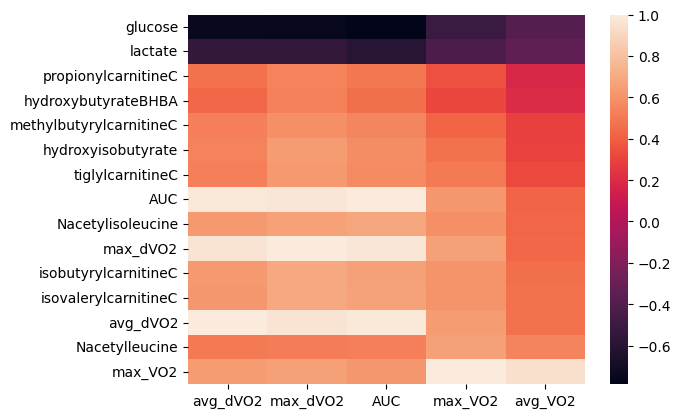

In [572]:
corr_matrix1 = muscle_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix2 = serum_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix1 = corr_matrix1.drop(corr_matrix1.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
corr_matrix2 = corr_matrix2.drop(corr_matrix2.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
sns.heatmap(corr_matrix1[abs(corr_matrix1.max_dVO2) > 0.5],annot=False)
plt.show()

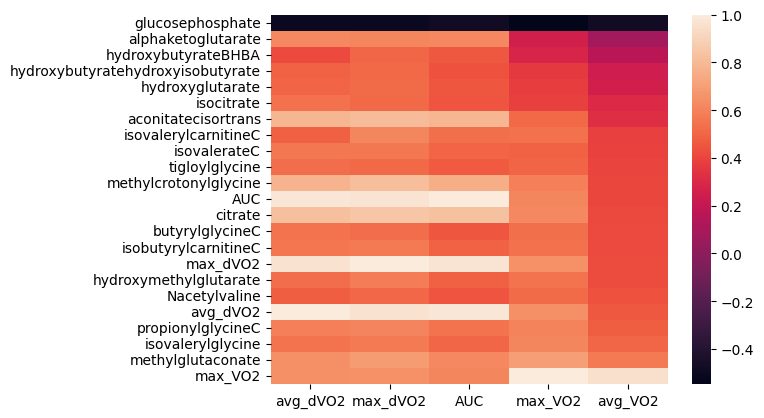

In [573]:
sns.heatmap(corr_matrix2[abs(corr_matrix2.max_dVO2) > 0.5],annot=False)
plt.show()

In [574]:
serum_adj = pd.DataFrame(columns=serum_fwn.columns)
results = pd.DataFrame(columns=['Metabolite','p_value','AIC','VS','VS_SDev','HS','HS_SDev','VR','VR_SDev','HR','HR_SDev'])
ancova_fwn = pd.merge(left=serum_fwn,
                      right=muscle_fwn[['hydroxybutyratehydroxyisobutyrate','glucose']].add_suffix('_mus'),how='left',left_index=True,right_index=True,)
covars=['avg_VO2','max_dVO2']
for met in ancova_fwn.columns[:-10]:
    # print(met) # for tracking progress in loop
    ancova_table = ancova(data=ancova_fwn, dv=f'{met}', covar=covars, between='Group')
    model = ols(formula=f'{met} ~ C(Tx) + C(Ex) + {covars[0]} + {covars[1]}', data=ancova_fwn).fit()
    # C(Group) tells the model to expect a categorical variable
    aic = model.aic
    # to get the adjusted means, use the fitted model to predict the values for each case, then subset based on group and then take the average and stdev
    group_means = model.predict(ancova_fwn.assign(Intercept=0))
    means = group_means[ancova_fwn['Group'] == 'VS'].mean(), group_means[ancova_fwn['Group'] == 'VR'].mean(), group_means[ancova_fwn['Group'] == 'HS'].mean(), group_means[ancova_fwn['Group'] == 'HR'].mean()
    std_dev = group_means[ancova_fwn['Group'] == 'VS'].std(), group_means[ancova_fwn['Group'] == 'VR'].std(), group_means[ancova_fwn['Group'] == 'HS'].std(), group_means[ancova_fwn['Group'] == 'HR'].std()

    serum_adj[met] = group_means

    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': ancova_table.iloc[0,4],
        'AIC': aic,
        'VS': means[0],
        'VR': means[1],
        'HS': means[2],
        'HR': means[3],
        'VS_SDev': std_dev[0],
        'VR_SDev': std_dev[1],
        'HS_SDev': std_dev[2],
        'HR_SDev': std_dev[3]
    })

results.to_csv('serum_EMM.csv')
serum_adj['Group'] = serum_fwn['Group']
serum_adj['Tx'] = serum_fwn['Tx']
serum_adj['Ex'] = serum_fwn['Ex']

In [575]:
muscle_adj = pd.DataFrame(columns=muscle_fwn.columns)
results = pd.DataFrame(columns=['Metabolite','p_value','AIC','VS','VS_SDev','HS','HS_SDev','VR','VR_SDev','HR','HR_SDev'])
ancova_fwn = pd.merge(left=muscle_fwn,
                      right=serum_fwn[['glucosephosphate','carnitine']].add_suffix('_ser'),how='left',left_index=True,right_index=True,)
# ancova_fwn = ancova_fwn[ancova_fwn.Ex == 'R']
covars=['avg_VO2','avg_dVO2']
for met in ancova_fwn.columns[:-10]:
    # print(met) # for tracking progress in loop
    ancova_table = ancova(data=ancova_fwn, dv=f'{met}', covar=covars, between='Tx')
    model = ols(formula=f'{met} ~ C(Tx) + C(Ex) + {covars[0]} + {covars[1]}', data=ancova_fwn).fit()
    # C(Group) tells the model to expect a categorical variable
    aic = model.aic
    # to get the adjusted means, use the fitted model to predict the values for each case, then subset based on group and then take the average and stdev
    group_means = model.predict(ancova_fwn.assign(Intercept=0))
    means = group_means[ancova_fwn['Group'] == 'VS'].mean(), group_means[ancova_fwn['Group'] == 'VR'].mean(), group_means[ancova_fwn['Group'] == 'HS'].mean(), group_means[ancova_fwn['Group'] == 'HR'].mean()
    std_dev = group_means[ancova_fwn['Group'] == 'VS'].std(), group_means[ancova_fwn['Group'] == 'VR'].std(), group_means[ancova_fwn['Group'] == 'HS'].std(), group_means[ancova_fwn['Group'] == 'HR'].std()

    muscle_adj[met] = group_means

    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': ancova_table.iloc[0,4],
        'AIC': aic,
        'VS': means[0],
        'VR': means[1],
        'HS': means[2],
        'HR': means[3],
        'VS_SDev': std_dev[0],
        'VR_SDev': std_dev[1],
        'HS_SDev': std_dev[2],
        'HR_SDev': std_dev[3]

    })

results.to_csv('muscle_EMM.csv')
muscle_adj['Group'] = muscle_fwn['Group']
muscle_adj['Tx'] = muscle_fwn['Tx']
muscle_adj['Ex'] = muscle_fwn['Ex']

In [576]:
muscle_adj

,alphaketoglutarate,hydroxyisobutyrate,hydroxymethylglutarate,phosphoglycerate,hypoxanthine,succinate,hydroxybutyrateBHBA,dihydroxyacetonephosphateDHAP,fumarate,isoleucine,...,hydroxybutyratehydroxyisobutyrate,dihydroxymethylbutyrate,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,-0.177572,0.613005,0.385909,0.369983,0.770753,-0.046645,0.237788,-0.190359,0.257555,0.596323,...,0.620973,0.728423,VR,V,R,NaN,NaN,NaN,NaN,NaN
VR60,-0.579506,0.489261,0.195994,0.456432,0.851370,-0.146585,0.061667,-0.104931,0.055230,0.781106,...,0.630739,0.641225,VR,V,R,NaN,NaN,NaN,NaN,NaN
VR83,0.840964,0.840478,1.158496,-0.444847,0.187881,0.194258,0.581963,-0.211286,0.171393,0.167406,...,0.931801,0.353215,VR,V,R,NaN,NaN,NaN,NaN,NaN
VR42,0.566091,0.903980,0.527441,0.639185,0.894302,0.147164,0.637217,-0.489280,1.063285,0.226097,...,0.361176,1.319207,VR,V,R,NaN,NaN,NaN,NaN,NaN
VR72,-0.635653,0.394329,0.432173,-0.068733,0.521237,-0.171686,-0.055034,0.083345,-0.513076,0.842395,...,0.934716,0.091429,VR,V,R,NaN,NaN,NaN,NaN,NaN
VR94,-0.495017,0.325320,0.878603,-0.876044,-0.000762,-0.152830,-0.126620,0.308516,-1.223398,0.829051,...,1.368996,-0.655664,VR,V,R,NaN,NaN,NaN,NaN,NaN
VS23,-0.184323,-0.806693,-0.357543,0.223265,-0.107103,-0.561306,-0.837193,-0.799880,0.127683,0.077686,...,-0.468005,0.353460,VS,V,S,NaN,NaN,NaN,NaN,NaN
VS61,-0.095634,-0.685292,-0.634005,0.855253,0.288833,-0.525753,-0.686721,-1.032434,0.826786,-0.006079,...,-0.836886,1.024218,VS,V,S,NaN,NaN,NaN,NaN,NaN
VS84,-0.173437,-0.791792,-0.391478,0.300838,-0.058504,-0.556942,-0.818724,-0.828425,0.213494,0.067404,...,-0.513284,0.435792,VS,V,S,NaN,NaN,NaN,NaN,NaN


In [577]:
results[results.p_value < 0.3].sort_values(by='p_value').reset_index()

,index,Metabolite,p_value,AIC,VS,VS_SDev,HS,HS_SDev,VR,VR_SDev,HR,HR_SDev
0,17,Nacetylleucine,0.001486,54.222402,-0.345828,0.261104,-0.962933,0.238311,0.992998,0.451666,0.315763,0.371136
1,31,Nacetylisoleucine,0.00511,54.234598,-0.478493,0.059231,-1.00183,0.054061,0.885831,0.304056,0.594492,0.284875
2,13,valine,0.007019,66.542453,0.177902,0.216304,-0.763064,0.197421,0.735524,0.445503,-0.150361,0.371943
3,35,isovalerylglycine,0.010006,60.301689,-0.233662,0.350258,-0.787932,0.319682,0.832246,0.600907,0.189348,0.493657
4,46,dihydroxymethylbutyrate,0.015257,63.165163,0.433331,0.495186,-0.661216,0.451958,0.412973,0.666605,-0.185087,0.578922
5,10,leucine,0.03632,72.379489,0.394724,0.009333,-0.570184,0.008519,0.445265,0.241558,-0.269806,0.241902
6,29,butyrylglycineC,0.039775,53.427509,-0.420675,0.584462,-0.524525,0.533441,0.831338,0.778076,0.113862,0.681648
7,9,isoleucine,0.043069,71.515256,0.067712,0.061839,-0.688119,0.056441,0.57373,0.305559,0.046677,0.285326
8,4,hypoxanthine,0.046955,67.837925,-0.059957,0.292299,-0.794434,0.266783,0.537464,0.372144,0.316928,0.383734
9,44,methylglutaconate,0.074517,62.944429,-0.515061,0.227268,-0.703775,0.207429,0.887762,0.286085,0.331074,0.286013


In [578]:
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
print(results.reject.value_counts())
results[results.reject == True]

reject
False    46
True      1
Name: count, dtype: int64


,Metabolite,p_value,AIC,VS,VS_SDev,HS,HS_SDev,VR,VR_SDev,HR,HR_SDev,adj_p,reject
17,Nacetylleucine,0.001486,54.222402,-0.345828,0.261104,-0.962933,0.238311,0.992998,0.451666,0.315763,0.371136,0.068333,True


### group comparisons and testing

In [579]:
grouped = muscle_adj.groupby('Group') # organize data by groups
results = pd.DataFrame(columns=['Metabolite', 'p_value']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in muscle_adj.columns[:-8]:
    VS = grouped.get_group('VS')[met]
    VR = grouped.get_group('VR')[met]
    HS = grouped.get_group('HS')[met]
    HR = grouped.get_group('HR')[met]
    #perform test
    test_stat, p_value = ttest_ind(VR, HR)
    # append data to the results table
    results.loc[len(results)] = pd.Series({'Metabolite': met,
                              'p_value': p_value})



In [580]:
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject


In [581]:
print(results.reject.value_counts())
results[results.reject == True]

reject
False    32
True     15
Name: count, dtype: int64


,Metabolite,p_value,adj_p,reject
5,succinate,0.000196,0.003327,True
6,hydroxybutyrateBHBA,0.014369,0.048856,True
7,dihydroxyacetonephosphateDHAP,0.000108,0.003327,True
9,isoleucine,0.011482,0.043375,True
10,leucine,0.000448,0.005081,True
13,valine,0.003853,0.019729,True
17,Nacetylleucine,0.017618,0.049918,True
21,carnitine,0.017155,0.049918,True
24,alphahydroxyisocaproate,0.000721,0.006131,True
36,methylbutyrylcarnitineC,0.004062,0.019729,True


### Attempting Two-Way ANOVA
Really just want an indication that there is an interaction between 2HB and exercise in modifying some of the metabolites

In [2820]:
results = pd.DataFrame(columns=['Metabolite', 'ME_Tx', 'ME_Ex', 'Interaction']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in df_fwn_scale.columns[:-3]:
    #create model and perform anova
    model = ols(f'{met} ~ C(Tx) + C(Ex) + C(Tx):C(Ex)', data=df_fwn_scale).fit()
    result = sm.stats.anova_lm(model, type=2)

    # main effect and interaction
    ME_Tx = result.iloc[0,4]
    ME_Ex = result.iloc[1,4]
    Interaction = result.iloc[1,4]
    # append data to the results table
    results.loc[len(results)] = pd.Series({'Metabolite': met,
                              'ME_Tx': ME_Tx,
                              'ME_Ex': ME_Ex,
                              'Interaction': Interaction})



reject
False    33
True     13
Name: count, dtype: int64


(array([13.,  6.,  3.,  4.,  0.,  2.,  0.,  6.,  4.,  8.]),
 array([0.00152436, 0.09999203, 0.19845971, 0.29692738, 0.39539505,
        0.49386273, 0.5923304 , 0.69079808, 0.78926575, 0.88773343,
        0.9862011 ]),
 <BarContainer object of 10 artists>)

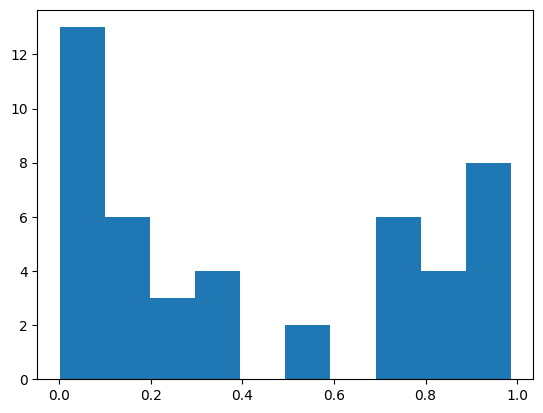

In [2821]:
reject, adj_pvalues, sidak, bonf = multipletests(
    results.Interaction.fillna(1), alpha=0.1, method = 'fdr_bh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
print(results.reject.value_counts())
plt.hist(results.adj_p)